In [2]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
t_hist = []
px_hist = []
py_hist = []
pz_hist = []
vx_hist = []
vy_hist = []
vz_hist = []
phi_hist = []
theta_hist = []
psi_hist = []
omegax_hist = []
omegay_hist = []
omegaz_hist = []

In [4]:
#constants / QuadCopter dimensions
g = 9.81 # gravity
k = 6.36105*10**-9  # propellar lift coefficient
b = 4.65133*10**-11  # drag coefficient

m_body = 0.7
l_body = 0.5
w_body = l_body
t_body = 0.1

m_arm = 0.05
l_arm = 0.4

l_rz = 0.05
#1 # z-distance between rotors and center of mass

In [5]:
def body_forces(w1, w2, w3, w4):
    taux = l_rz * k * (-w2**2 + w4**2)
    tauy = l_rz * k * (-w1**2 + w3**2)
    tauz = l_rz * b * (w1**2 - w2**2 + w3**2 - w4**2)

    fz = k * (w1**2 + w2**2 + w3**2 + w4**2)

    return taux, tauy, tauz, fz

In [6]:
#calcs moments of inertia 
m = 4*m_arm + m_body

I_xx_body = 1/12 * m_body*(w_body**2 + t_body**2)
I_yy_body = 1/12 * m_body*(l_body**2 + t_body**2)
I_zz_body = 1/12 * m_body *(w_body**2 + l_body**2)

I_xx_arm = 0
I_yy_arm = 1/12 * m_arm * l_arm**2 + m_arm * (l_arm/2 + l_body/2)**2
I_zz_arm = I_yy_arm

Ixx = 4*I_xx_arm + I_xx_body
Iyy = 2*I_yy_arm + I_yy_body
Izz = 4*I_zz_arm + I_zz_body


In [7]:
def quad_EOM(t, q, taux, tauy, tauz, fz):

    #must be first-order ODES
    '''
    Arguements:
        q : state vector :
        [px, py, pz, vx, vy, vz, phi, theta, psi, 
        omegax, omegay, omegaz, taux, tauy, tauz, fz]

        t : time
        p : various vector parameters : 
        [m, Ixx, Iyy, Izz]
    '''

    px, py, pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz = q

    C_phi = np.cos(phi)
    C_theta = np.cos(theta)
    C_psi = np.cos(psi)
    
    S_phi = np.sin(phi)
    S_theta = np.sin(theta)
    S_psi = np.sin(psi)

    px_dot = vx*C_psi*C_theta + vy*(S_phi*S_theta*C_psi - S_psi * C_phi) + vz * (S_phi * S_psi + S_theta*C_phi*C_psi)
    py_dot = vx*S_psi*C_theta + vy*(S_phi * S_psi *S_theta + C_phi*C_psi) - vz*(S_phi*C_psi - S_psi*S_theta*C_phi)
    pz_dot = -vx*S_theta + vy*S_phi*C_theta + vz * C_phi * C_theta

    vx_dot = -omegay*vz + omegaz*vy + g*S_theta
    vy_dot = omegax*vz - omegaz*vx - g*S_phi*C_theta
    vz_dot = fz/m - omegax*vy + omegay*vx - g*C_phi*C_theta

    phi_dot = omegax + omegay*S_phi*S_theta/C_theta + omegaz*C_phi*S_theta/C_theta
    theta_dot = omegay*C_phi - omegaz*S_phi
    psi_dot = 1/C_theta * (omegay*S_phi + omegaz*C_phi)

    omegax_dot = 1/Ixx * (Iyy*omegay*omegaz - Izz*omegay*omegaz + taux)
    omegay_dot = 1/Iyy * (-Ixx*omegax*omegaz + Izz*omegax * omegaz + tauy)
    omegaz_dot = 1/Izz * (Ixx*omegax*omegay - Iyy*omegax*omegay + tauz)



    EOM = [px_dot, py_dot, pz_dot, 
           vx_dot, vy_dot, vz_dot,
           phi_dot, theta_dot, psi_dot,
           omegax_dot, omegay_dot, omegaz_dot]
    
    return EOM 

In [8]:
F_net = m*g

w = np.sqrt(F_net/(4*k))
F_net

8.828999999999999

In [9]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548 + 50
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz

8.87717917240671

In [10]:
#up1

#init_conditions
px0 = 0
py0 = 0
pz0 = 0
vx0 = 0
vy0 = 0
vz0 = 0
phi0 = 0
theta0 = 0
psi0 = 0
omegax0 = 0
omegay0 = 0
omegaz0 = 0

t = (0, 4.321)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)


t_hist = list(sol.t)
px_hist = list(sol.y[0])
py_hist = list(sol.y[1])
pz_hist = list(sol.y[2])
vx_hist = list(sol.y[3])
vy_hist = list(sol.y[4])
vz_hist = list(sol.y[5])
phi_hist = list(sol.y[6])
theta_hist = list(sol.y[7])
psi_hist = list(sol.y[8])
omegax_hist = list(sol.y[9])
omegay_hist = list(sol.y[10])
omegaz_hist = list(sol.y[11])

In [11]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548 - 52
    #clockwise
w1 = w
w3 = w 
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz

8.780490713352624

In [12]:
#up2 

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (t_hist[-1], 8.612)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)


para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])


EVERYTHING GOOD UP TO HERE

In [13]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w-500
w3 = w+500
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)

(0.0, 0.011849711969471351, 1.1628325e-06, 8.832897239028824)

In [14]:
#rotate around phi

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (9.911, 10.6)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [15]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w +1500
w3 = w -1500
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, -0.03554913590841405, 1.04654925e-05, 8.858341439028825)

In [16]:
#stops rotating around phi

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (10.6, 10.95)#10.085)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [17]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, 0.0, 0.0, 8.829716714028825)

In [18]:
#stops rotating around phi

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (10.95, 11.6)#10.085)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [19]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w - 544
w3 = w + 544
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, 0.012892486622784843, 1.3764959948798613e-06, 8.833481641414425)

In [20]:
#stops rotating around phi

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (11.6, 11.94)#10.085)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

EVERYTHING IS GOOD UP TO HERE

In [21]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548 + 5
    #clockwise
w1 = w 
w3 = w 
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, 0.0, 0.0, 8.834457234921613)

In [22]:
#moves forward

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (11.94, 15.3)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [23]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w + 2050
w3 = w - 2000
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, -0.04805573910760898, 2.3408643167637415e-05, 8.893742938623294)

In [24]:
#stops moving forward

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (15.3, 15.71)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [25]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w-2846
w3 = w+2846
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)

(0.0, 0.06744856053023093, 3.767445202227986e-05, 8.932762110952424)

In [26]:
#stops moving forward

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (15.71, 16.455)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [27]:
#controls
#propeller controls
W = 8.828999999999999
w = 18627.79106464644
    #clockwise
w1 = w + 18627.79106464644
w3 = w - 18627.79106464644
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)

(0.0, -0.44145000000000006, 0.0016139863925766973, 13.243500000000001)

In [28]:
#stops moving forward

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (16.455, 16.525)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

SECOND HOVER POSITION (REST STATE)

In [29]:
#controls
#propeller controls
W = 8.828999999999999
w = 18627.79106464644
    #clockwise
cw = 2726
w1 = w + cw
w3 = w + cw
    #counter-clockwise
ccw = 3200#1.027592459233804 * cw
w2 = w - ccw
w4 = w - ccw

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, 0.0, 0.0010138394959786606, 8.829151775552646)

In [30]:
#yaw

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = 0
vy0 = 0
vz0 = 0
phi0 = 0
theta0 = 0
psi0 = 0
omegax0 = 0
omegay0 = 0
omegaz0 = 0

t = (16.525, 27)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [31]:
#controls
#propeller controls
W = 8.828999999999999
w = 18627.79106464644
    #clockwise
cw = 3200
w1 = w - cw
w3 = w - cw
    #counter-clockwise
ccw = 2725.72
w2 = w + ccw
w4 = w + ccw

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, 0.0, -0.0010137838751670888, 8.82899964411349)

In [32]:
#yaw

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (27, 37.75)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

STABLE - YAWED

In [33]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w-500
w3 = w+500
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)

(0.0, 0.011849711969471351, 1.1628325e-06, 8.832897239028824)

In [34]:
#new straight

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (37.75, 38.439)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [35]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w +1500
w3 = w -1500
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, -0.03554913590841405, 1.04654925e-05, 8.858341439028825)

In [36]:
#new straight

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (38.439, 38.789)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [37]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, 0.0, 0.0, 8.829716714028825)

In [38]:
#new straight

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (38.789, 39.439)


init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [39]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w - 544
w3 = w + 544
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, 0.012892486622784843, 1.3764959948798613e-06, 8.833481641414425)

In [40]:
#new straight

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (39.439, 39.779)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [41]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548 + 5
    #clockwise
w1 = w 
w3 = w 
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, 0.0, 0.0, 8.834457234921613)

In [42]:
#new straight

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (39.779, 43.139)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

workin so far

In [43]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w + 2050
w3 = w - 2000
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
body_forces(w1, w2, w3, w4)

(0.0, -0.04805573910760898, 2.3408643167637415e-05, 8.893742938623294)

In [44]:
#new straight

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (43.139, 43.549)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [45]:
#controls
#propeller controls
W = 8.828999999999999
w = 18628.547125822548
    #clockwise
w1 = w-2846
w3 = w+2846
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)
t = (15.71, 16.455)

In [46]:
#new straight

#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (43.549, 44.294)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [47]:
#controls
#propeller controls
W = 8.828999999999999
w = 18627.79106464644
    #clockwise
w1 = w + 18627.79106464644
w3 = w - 18627.79106464644
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)

(0.0, -0.44145000000000006, 0.0016139863925766973, 13.243500000000001)

In [48]:
#new straight
#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (44.294, 44.364)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

START DESCENT

In [49]:
#controls
#propeller controls
W = 8.828999999999999
w = 18627.79106464644-2000
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)

(0.0, 0.0, 0.0, 7.034899834371693)

In [50]:
#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = 0
vy0 = 0
vz0 = vz_hist[-1]
phi0 = 0
theta0 = 0
psi0 = 0
omegax0 = 0
omegay0 = 0
omegaz0 = 0

t = (44.364, 44.8)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [51]:
#controls
#propeller controls
W = 8.828999999999999
w = 18627.79106464644 
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)

(0.0, 0.0, 0.0, 8.829)

In [52]:
#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (44.8, 46.3)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [53]:
#controls
#propeller controls
W = 8.828999999999999
w = 18627.79106464644 + 400
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)

(0.0, 0.0, 0.0, 9.212246465125661)

In [54]:
#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (46.3, 47.3956)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

In [55]:
#controls
#propeller controls
W = 8.828999999999999
w = 18627.79106464644
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w

body_forces(w1, w2, w3, w4)
#47.091822474820404 * np.cos(init_theta)
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)
fz
body_forces(w1, w2, w3, w4)

(0.0, 0.0, 0.0, 8.829)

In [56]:
#init_conditions
px0 = px_hist[-1]
py0 = py_hist[-1]
pz0 = pz_hist[-1]
vx0 = vx_hist[-1]
vy0 = vy_hist[-1]
vz0 = vz_hist[-1]
phi0 = phi_hist[-1]
theta0 = theta_hist[-1]
psi0 = psi_hist[-1]
omegax0 = omegax_hist[-1]
omegay0 = omegay_hist[-1]
omegaz0 = omegaz_hist[-1]

t = (47.596, 54.2)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

t_hist = t_hist + list(sol.t)
px_hist = px_hist + list(sol.y[0])
py_hist = py_hist + list(sol.y[1])
pz_hist = pz_hist + list(sol.y[2])
vx_hist = vx_hist + list(sol.y[3])
vy_hist = vy_hist + list(sol.y[4])
vz_hist= vz_hist + list(sol.y[5])
phi_hist = phi_hist + list(sol.y[6])
theta_hist = theta_hist + list(sol.y[7])
psi_hist = psi_hist + list(sol.y[8])
omegax_hist = omegax_hist + list(sol.y[9])
omegay_hist = omegay_hist + list(sol.y[10])
omegaz_hist = omegaz_hist + list(sol.y[11])

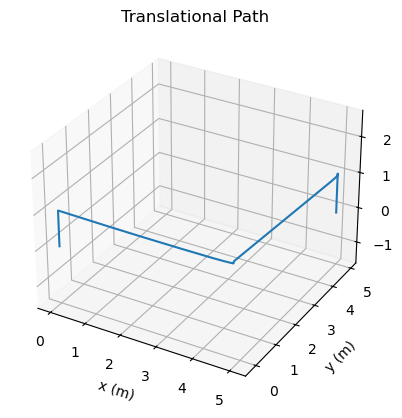

In [62]:
fig = plt.figure()
pax = fig.add_subplot(111, projection='3d')

pax.plot(px_hist, py_hist, pz_hist)
pax.axis('equal')

pax.set_title('Translational Path')
pax.set_xlabel('x (m)')
pax.set_ylabel('y (m)')
pax.set_zlabel('z (m)')
fig.savefig(fname = 'complex_path', dpi = 1200)
plt.show()

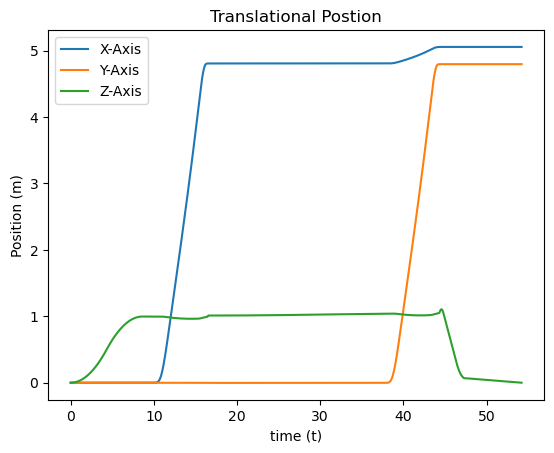

In [58]:
#position
fig, pax = plt.subplots()
pax.plot(t_hist, px_hist, label = 'X-Axis')
pax.plot(t_hist, py_hist, label = 'Y-Axis')
pax.plot(t_hist, pz_hist, label = 'Z-Axis')

pax.set_title('Translational Postion')
pax.set_xlabel('time (t)')
pax.set_ylabel('Position (m)')
pax.legend()
fig.savefig(fname = 'complex_trans', dpi = 1200)
plt.show()

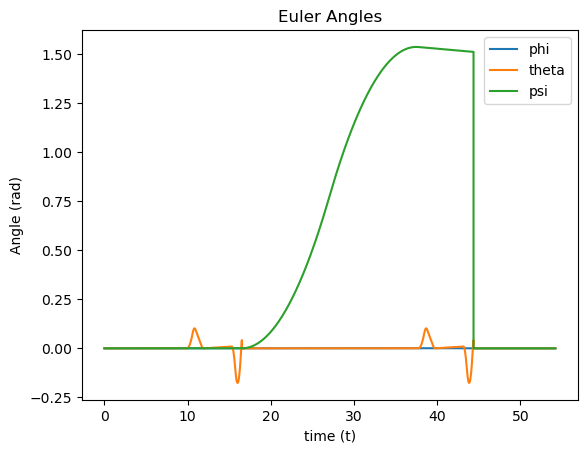

In [59]:
#bryan-tait
fig, pax = plt.subplots()
pax.plot(t_hist, phi_hist, label = 'phi')
pax.plot(t_hist, theta_hist, label = 'theta')
pax.plot(t_hist, psi_hist, label = 'psi')

pax.set_title('Euler Angles')
pax.set_xlabel('time (t)')
pax.set_ylabel('Angle (rad)')
pax.legend()
fig.savefig(fname = 'complex_euler', dpi = 1200)
plt.show()

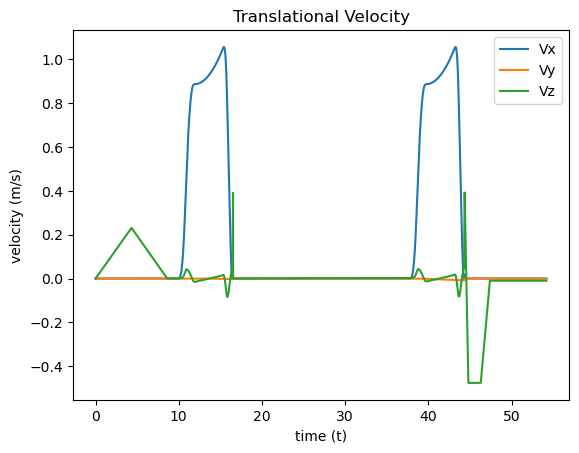

In [60]:
#linear velcity
fig, pax = plt.subplots()
pax.plot(t_hist, vx_hist, label = 'Vx')
pax.plot(t_hist, vy_hist, label = 'Vy')
pax.plot(t_hist, vz_hist, label = 'Vz')

pax.set_title('Translational Velocity')
pax.set_xlabel('time (t)')
pax.set_ylabel('velocity (m/s)')
pax.legend()
fig.savefig(fname = 'complex_vel', dpi = 1200)
plt.show()

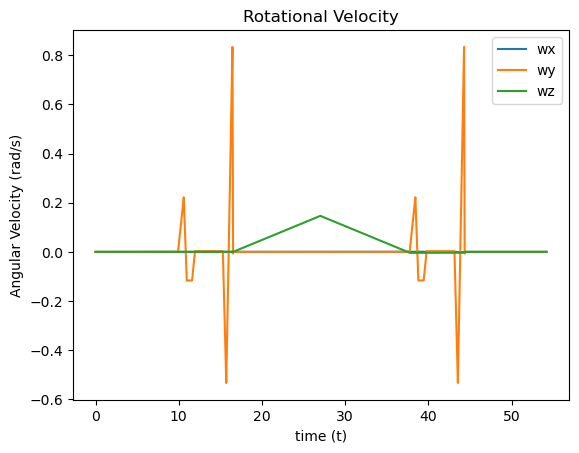

In [61]:
#rot velocity
fig, pax = plt.subplots()
pax.plot(t_hist, omegax_hist, label = 'wx')
pax.plot(t_hist, omegay_hist, label = 'wy')
pax.plot(t_hist, omegaz_hist, label = 'wz')

pax.set_title('Rotational Velocity')
pax.set_xlabel('time (t)')
pax.set_ylabel('Angular Velocity (rad/s)')
pax.legend()
fig.savefig(fname = 'complex_w', dpi = 1200)
plt.show()